In [4]:
# Step 1: Import Libraries and Load Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load sales and ingredient datasets
sales_df = pd.read_csv(r"C:\Users\Vishwa\Desktop\GUVI captone\Dominos\Pizza_Sale - pizza_sales.csv")
ingredients_df = pd.read_csv(r"C:\Users\Vishwa\Desktop\GUVI captone\Dominos\Pizza_ingredients - Pizza_ingredients.csv")

In [10]:
# Step 2: Data Cleaning
sales_df['order_date'] = pd.to_datetime(sales_df['order_date'], errors='coerce', dayfirst=True)
sales_df['day'] = sales_df['order_date'].dt.day
sales_df['month'] = sales_df['order_date'].dt.month
sales_df['year'] = sales_df['order_date'].dt.year
sales_df['weekday'] = sales_df['order_date'].dt.day_name()

missing_values = sales_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 pizza_id                 0
order_id                 0
pizza_name_id           16
quantity                 0
order_date           29033
order_time               0
unit_price               0
total_price              7
pizza_size               0
pizza_category          23
pizza_ingredients       13
pizza_name               7
day                  29033
month                29033
year                 29033
weekday              29033
dtype: int64


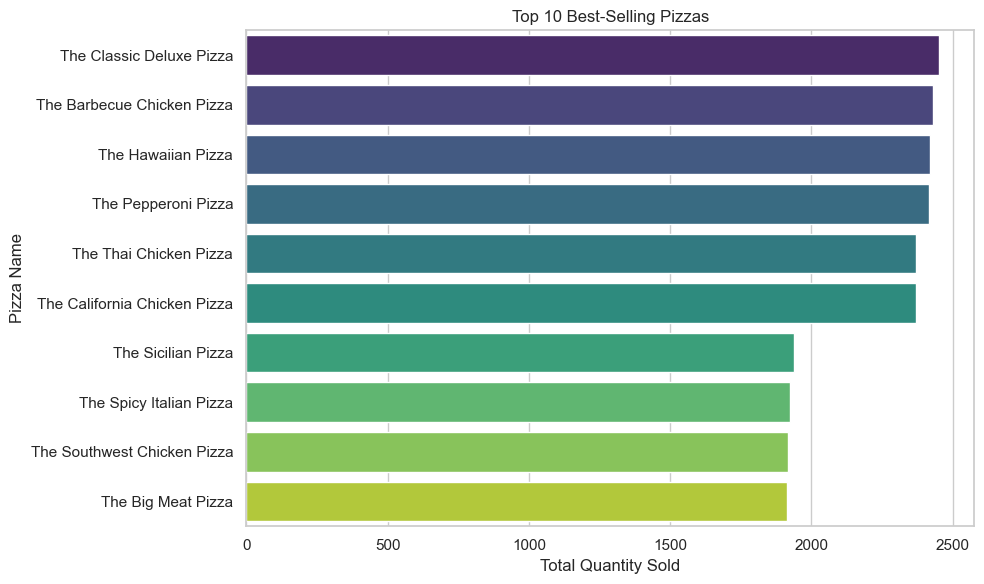

In [18]:
# Step 3: EDA
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
top_pizzas = sales_df.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_pizzas.values, y=top_pizzas.index, palette="viridis")
plt.title("Top 10 Best-Selling Pizzas")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Pizza Name")
plt.tight_layout()
plt.show()

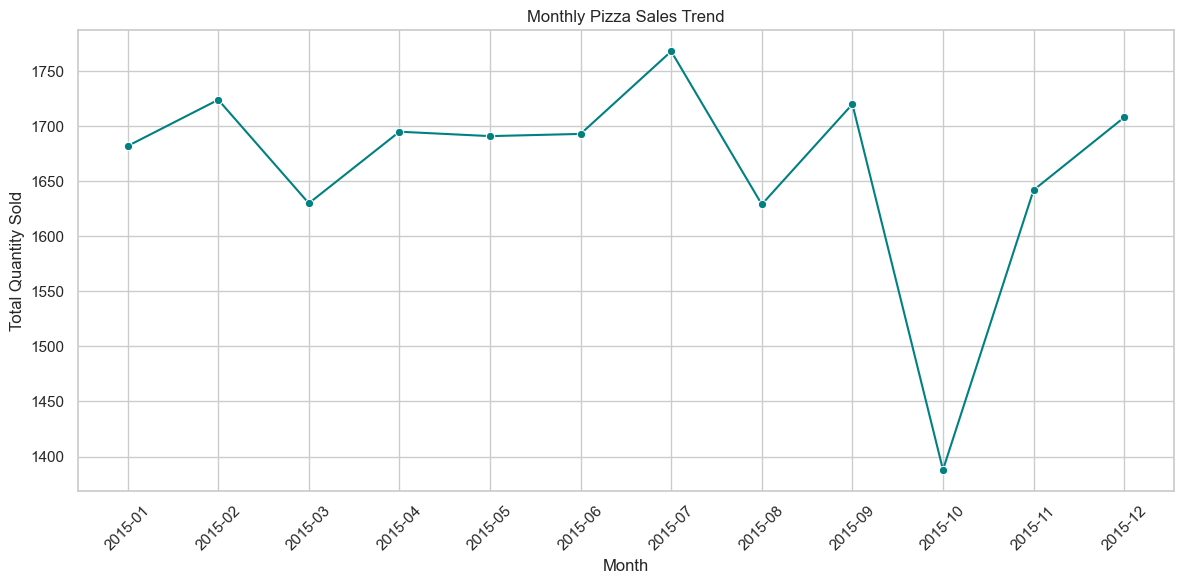

In [20]:
monthly_sales = sales_df.groupby(sales_df['order_date'].dt.to_period("M"))['quantity'].sum()
monthly_sales.index = monthly_sales.index.astype(str)
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, marker='o', color='teal')
plt.title("Monthly Pizza Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

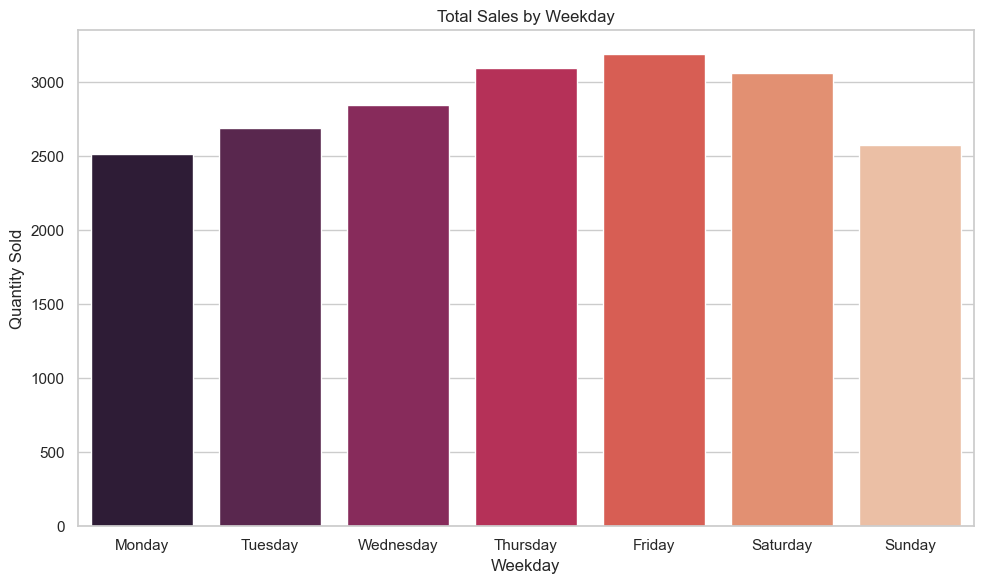

In [22]:
weekday_sales = sales_df.groupby('weekday')['quantity'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(10,6))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette="rocket")
plt.title("Total Sales by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Quantity Sold")
plt.tight_layout()
plt.show()

In [ ]:
# Step 4: Sales Forecasting with Prophet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Aggregate total quantity sold per day
daily_sales = sales_df.groupby('order_date')['quantity'].sum().reset_index()
daily_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' and 'y'

# Initialize and fit the model
model = Prophet()
model.fit(daily_sales)

# Forecast for next 7 days
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)

# Plot forecast
fig = model.plot(forecast)
plt.title("Sales Forecast for Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Quantity")
plt.tight_layout()
plt.show()

# Show forecasted values
forecast_result = forecast[['ds', 'yhat']].tail(7)
print("\nForecasted Sales for Next 7 Days:\n", forecast_result)

In [28]:
# Step 5: Purchase Order Generation (Prophet)
# Estimate average pizza sales ratio by type
pizza_ratios = sales_df.groupby('pizza_name_id')['quantity'].sum() / sales_df['quantity'].sum()

# Estimate pizza-wise forecast for next 7 days
avg_daily_pred = forecast_result['yhat'].mean()
pizza_forecast = (pizza_ratios * avg_daily_pred * 7).reset_index()
pizza_forecast.columns = ['pizza_name_id', 'forecasted_quantity']

# Merge with ingredient data
purchase_order = pd.merge(pizza_forecast, ingredients_df, on='pizza_name_id', how='left')

# Calculate total quantity of each ingredient required
purchase_order['total_ingredient_qty'] = purchase_order['forecasted_quantity'] * purchase_order['Items_Qty_In_Grams']
ingredient_summary = purchase_order.groupby('pizza_ingredients')['total_ingredient_qty'].sum().reset_index()
ingredient_summary.columns = ['Ingredient', 'Total_Required_Grams']

# Show final purchase order
ingredient_summary = ingredient_summary.sort_values(by='Total_Required_Grams', ascending=False)
print("\n=== Purchase Order for Next 7 Days ===")
print(ingredient_summary)


=== Purchase Order for Next 7 Days ===
             Ingredient  Total_Required_Grams
15              Chicken          19134.365767
51           Red Onions          17012.221098
13            Capocollo          15203.483295
62             Tomatoes          11703.806122
6                 Bacon           9886.991838
..                  ...                   ...
24  Friggitello Peppers            202.010522
42                Pears             96.523799
61                Thyme             48.261900
55           Sliced Ham              0.000000
14   Caramelized Onions              0.000000

[64 rows x 2 columns]


In [34]:
# Step 4: Sales Forecasting - ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare daily sales data
daily_sales = sales_df.groupby('order_date')['quantity'].sum()

# Fit ARIMA model (simple example order (5,1,2))
arima_model = ARIMA(daily_sales, order=(5,1,2))
arima_result = arima_model.fit()

# Forecast next 7 days
arima_forecast = arima_result.forecast(steps=7)
print("\nARIMA Forecast (Next 7 Days):\n", arima_forecast)

C:\Users\Vishwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Vishwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Vishwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA Forecast (Next 7 Days):
 142    137.208233
143    142.592644
144    139.175599
145    143.814071
146    137.415340
147    143.333887
148    137.688877
Name: predicted_mean, dtype: float64


C:\Users\Vishwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [36]:
# Step 5: Sales Forecasting - SARIMA Model
# Fit SARIMA model (example order=(1,1,1) with seasonal_order=(1,1,1,7))
sarima_model = SARIMAX(daily_sales, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_result = sarima_model.fit(disp=False)

# Forecast next 7 days
sarima_forecast = sarima_result.forecast(steps=7)
print("\nSARIMA Forecast (Next 7 Days):\n", sarima_forecast)



C:\Users\Vishwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Vishwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



SARIMA Forecast (Next 7 Days):
 142    135.355724
143    132.596758
144    144.404879
145    143.832902
146    134.809891
147    147.694776
148    139.112476
Name: predicted_mean, dtype: float64


C:\Users\Vishwa\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [48]:
#Final Purchase Order Decision using SARIMA
# Calculate average daily prediction from SARIMA forecast
avg_daily_pred = sarima_forecast.mean()

# Estimate pizza-wise forecast for next 7 days
pizza_ratios = sales_df.groupby('pizza_name_id')['quantity'].sum() / sales_df['quantity'].sum()
pizza_forecast = (pizza_ratios * avg_daily_pred * 7).reset_index()
pizza_forecast.columns = ['pizza_name_id', 'forecasted_quantity']

# Merge with ingredients
ingredient_data = pd.merge(pizza_forecast, ingredients_df, on='pizza_name_id', how='left')
ingredient_data['total_ingredient_qty'] = ingredient_data['forecasted_quantity'] * ingredient_data['Items_Qty_In_Grams']
ingredient_summary = ingredient_data.groupby('pizza_ingredients')['total_ingredient_qty'].sum().reset_index()
ingredient_summary.columns = ['Ingredient', 'Total_Required_Grams']
ingredient_summary = ingredient_summary.sort_values(by='Total_Required_Grams', ascending=False)

print("\n=== Final Purchase Order Using Best Model (SARIMA in this case) ===")
print(ingredient_summary)



=== Final Purchase Order Using Best Model (SARIMA in this case) ===
             Ingredient  Total_Required_Grams
15              Chicken          19159.099989
51           Red Onions          17034.212109
13            Capocollo          15223.136224
62             Tomatoes          11718.935159
6                 Bacon           9899.772353
..                  ...                   ...
24  Friggitello Peppers            202.271653
42                Pears             96.648572
61                Thyme             48.324286
55           Sliced Ham              0.000000
14   Caramelized Onions              0.000000

[64 rows x 2 columns]


In [38]:
# Step 6: LSTM Model Forecasting
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(np.array(daily_sales).reshape(-1,1))

X, y = [], []
for i in range(10, len(scaled_sales)):
    X.append(scaled_sales[i-10:i, 0])
    y.append(scaled_sales[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1],1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=16, verbose=0)

x_input = scaled_sales[-10:].reshape(1,10,1)
lstm_forecast = []
for _ in range(7):
    next_val = model.predict(x_input, verbose=0)
    lstm_forecast.append(scaler.inverse_transform(next_val)[0][0])
    x_input = np.append(x_input[:,1:,:], next_val.reshape(1,1,1), axis=1)

print("\nLSTM Forecast (Next 7 Days):\n", lstm_forecast)


LSTM Forecast (Next 7 Days):
 [141.665, 141.56883, 140.00777, 139.1951, 139.05692, 138.6956, 139.87076]


In [40]:
# Step 7: Linear Regression Forecasting
from sklearn.linear_model import LinearRegression

df_lr = daily_sales.reset_index()
df_lr['t'] = range(len(df_lr))
X_lr = df_lr[['t']]
y_lr = df_lr['quantity']

model_lr = LinearRegression()
model_lr.fit(X_lr, y_lr)

future_t = pd.DataFrame({'t': range(len(df_lr), len(df_lr)+7)})
lr_forecast = model_lr.predict(future_t)

print("\nLinear Regression Forecast (Next 7 Days):\n", lr_forecast)


Linear Regression Forecast (Next 7 Days):
 [139.96074318 139.95132976 139.94191634 139.93250292 139.9230895
 139.91367608 139.90426265]


In [44]:
#Step 8: Purchase Order Generation
pizza_ratios = sales_df.groupby('pizza_name_id')['quantity'].sum() / sales_df['quantity'].sum()
avg_daily_pred = forecast_result['yhat'].mean()
pizza_forecast = (pizza_ratios * avg_daily_pred * 7).reset_index()
pizza_forecast.columns = ['pizza_name_id', 'forecasted_quantity']

purchase_order = pd.merge(pizza_forecast, ingredients_df, on='pizza_name_id', how='left')
purchase_order['total_ingredient_qty'] = purchase_order['forecasted_quantity'] * purchase_order['Items_Qty_In_Grams']
ingredient_summary = purchase_order.groupby('pizza_ingredients')['total_ingredient_qty'].sum().reset_index()
ingredient_summary.columns = ['Ingredient', 'Total_Required_Grams']
ingredient_summary = ingredient_summary.sort_values(by='Total_Required_Grams', ascending=False)

print("\n=== Purchase Order for Next 7 Days ===")
print(ingredient_summary)



=== Purchase Order for Next 7 Days ===
             Ingredient  Total_Required_Grams
15              Chicken          19134.365767
51           Red Onions          17012.221098
13            Capocollo          15203.483295
62             Tomatoes          11703.806122
6                 Bacon           9886.991838
..                  ...                   ...
24  Friggitello Peppers            202.010522
42                Pears             96.523799
61                Thyme             48.261900
55           Sliced Ham              0.000000
14   Caramelized Onions              0.000000

[64 rows x 2 columns]


In [50]:
# Step 8: Business Impact & Recommendation
print("\n=== Business Impact & Recommendation ===")
print("1. Accurate forecasting reduces overstocking and understocking, optimizing inventory management.")
print("2. Helps avoid ingredient wastage and manage shelf life more efficiently.")
print("3. Ensures better supply chain coordination and timely replenishment.")
print("4. Enables data-driven decision-making for promotions, staffing, and logistics.")
print("5. Recommendation: Regularly retrain models with updated sales data for sustained accuracy and automation.")



=== Business Impact & Recommendation ===
1. Accurate forecasting reduces overstocking and understocking, optimizing inventory management.
2. Helps avoid ingredient wastage and manage shelf life more efficiently.
3. Ensures better supply chain coordination and timely replenishment.
4. Enables data-driven decision-making for promotions, staffing, and logistics.
5. Recommendation: Regularly retrain models with updated sales data for sustained accuracy and automation.
